In [1]:
knitr::opts_chunk$set(echo = TRUE)
library(tidyverse)
library(viridis)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: viridisLite



# 1. Overview
Bella Beat is a high-tech manufacturer of health-focused products for women. As an analyst, my task is to analyze smart device usage data for non-Bella Beat products in order to gain insight into how consumers use these devices. This information will then be used to select Bella Beat products (Bella Beat app, Leaf (wellness tracker), Time (watch), Spring (water bottle), and Bella Beat membership) and apply the insights to them in a presentation. The goal is to use the analysis to inform Bella Beat’s marketing strategy and identify new growth opportunities for the company. The analysis will be guided by questions about consumer usage of smart devices and will be presented to the Bella Beat executive team along with high-level recommendations for the company’s marketing strategy.

In [2]:
activitylog = read_csv("/kaggle/input/bella-beats-google-analytics-data/dailyActivity_merged.csv")
sleeplog = read_csv("/kaggle/input/bella-beats-google-analytics-data/sleepDay_merged.csv")

head(activitylog)
head(sleeplog)

Rows: 940 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ActivityDate
dbl (14): Id, TotalSteps, TotalDistance, TrackerDistance, LoggedActivitiesDi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 413 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): SleepDay
dbl (4): Id, TotalSleepRecords, TotalMinutesAsleep, TotalTimeInBed

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1503960366,4/12/2016,13162,8.50,8.50,0,1.88,0.55,6.06,0,25,13,328,728,1985
1503960366,4/13/2016,10735,6.97,6.97,0,1.57,0.69,4.71,0,21,19,217,776,1797
1503960366,4/14/2016,10460,6.74,6.74,0,2.44,0.40,3.91,0,30,11,181,1218,1776
1503960366,4/15/2016,9762,6.28,6.28,0,2.14,1.26,2.83,0,29,34,209,726,1745
1503960366,4/16/2016,12669,8.16,8.16,0,2.71,0.41,5.04,0,36,10,221,773,1863
1503960366,4/17/2016,9705,6.48,6.48,0,3.19,0.78,2.51,0,38,20,164,539,1728


Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1503960366,4/12/2016 12:00:00 AM,1,327,346
1503960366,4/13/2016 12:00:00 AM,2,384,407
1503960366,4/15/2016 12:00:00 AM,1,412,442
1503960366,4/16/2016 12:00:00 AM,2,340,367
1503960366,4/17/2016 12:00:00 AM,1,700,712
1503960366,4/19/2016 12:00:00 AM,1,304,320


# 2. Explaining the Purpose of the Chosen Data
The selected datasets, activity log and sleep log, provide valuable insights into how non-Bella Beat smart devices are utilized for health monitoring. Analyzing daily activity levels and sleep patterns will reveal users' behavior patterns. We will explore correlations between activity levels, calorie expenditure etc. Identifying habits among successful calorie burners and individuals with better sleep quality will inform the wellness tracker app's development. These insights will guide Bella Beat's marketing strategy, enhancing their products' appeal and identifying growth opportunities.

# 3. Data Cleaning

In [3]:
#Converting Date Columns to the correct data type
activitylog$ActivityDate = as.Date(activitylog$ActivityDate, format = "%m/%d/%Y")
sleeplog$SleepDay = as.Date(sleeplog$SleepDay, format = "%m/%d/%Y")

#Checking for NA values
activityNA = colSums(is.na(activitylog))
sleepNA = colSums(is.na(sleeplog))

#There are Rows with Missing Data in Activity DF labeled as zero, so these rows need to be removed. The calories column has data even when some corresponding columns do not have any data. Some of the individuals do not have as many data points as others. Unrepresentative participants will be removed. 

activitylog = activitylog[,-which(colnames(activitylog) == "LoggedActivitiesDistance")] #LoggedActivitiesDistance has No values, hence removed

zero_count = activitylog %>% group_by(Id) %>% summarize(zero_count = sum(TotalSteps == 0))
#Zero_Count holds the IDs and the total 0s each Id has for the TotalSteps Column 
head(zero_count)

#factivitylog removes the IDs with zero_count more than 5. To clarify if, after inspection, it was observed that if the totalSteps column has "0" as values then the subsequent columns also had no meaningful values, hence their removal
factivitylog = activitylog %>% filter(Id %in% zero_count[zero_count$zero_count < 6, ]$Id)

#This removes an outlier Id 
factivitylog  = factivitylog[-which(factivitylog$Id == 4057192912),]

#Removing the Redundant IDs from the other Dataframes
fsleeplog = sleeplog %>% filter(Id %in% zero_count[zero_count$zero_count < 6, ]$Id)


#IDs are Factors therefore will be changed accordingly
factivitylog$Id = factor(factivitylog$Id)
fsleeplog$Id = factor(fsleeplog$Id)

#New Column for total time (minutes)
factivitylog = factivitylog %>% mutate(Total_Time = VeryActiveMinutes+ FairlyActiveMinutes+LightlyActiveMinutes)


Id,zero_count
<dbl>,<int>
1503960366,1
1624580081,0
1644430081,0
1844505072,10
1927972279,14
2022484408,0


# 4. Data Investigation

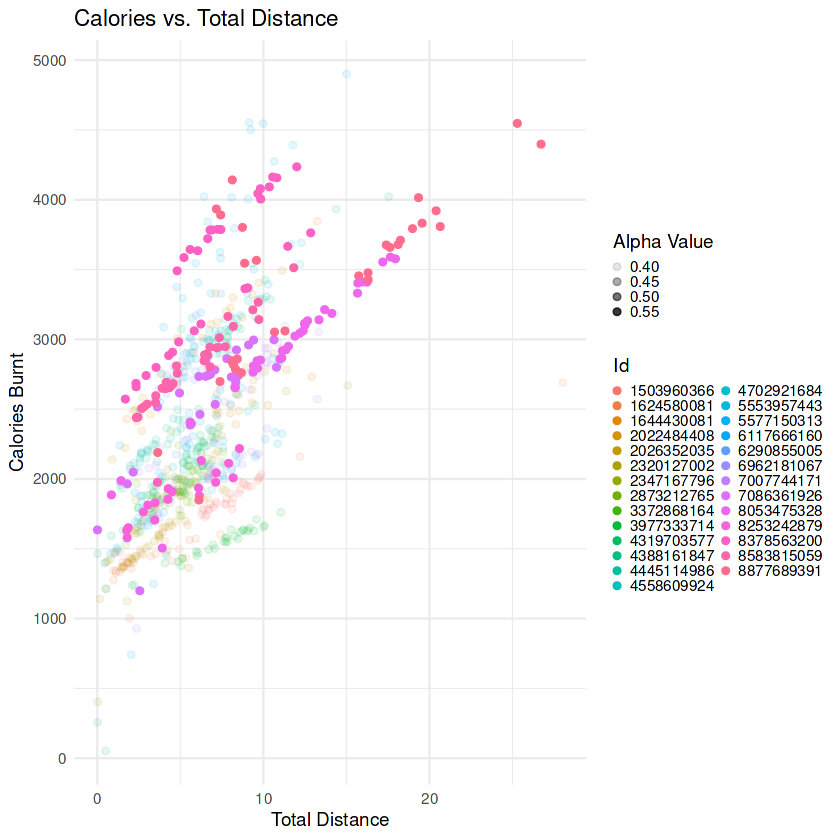

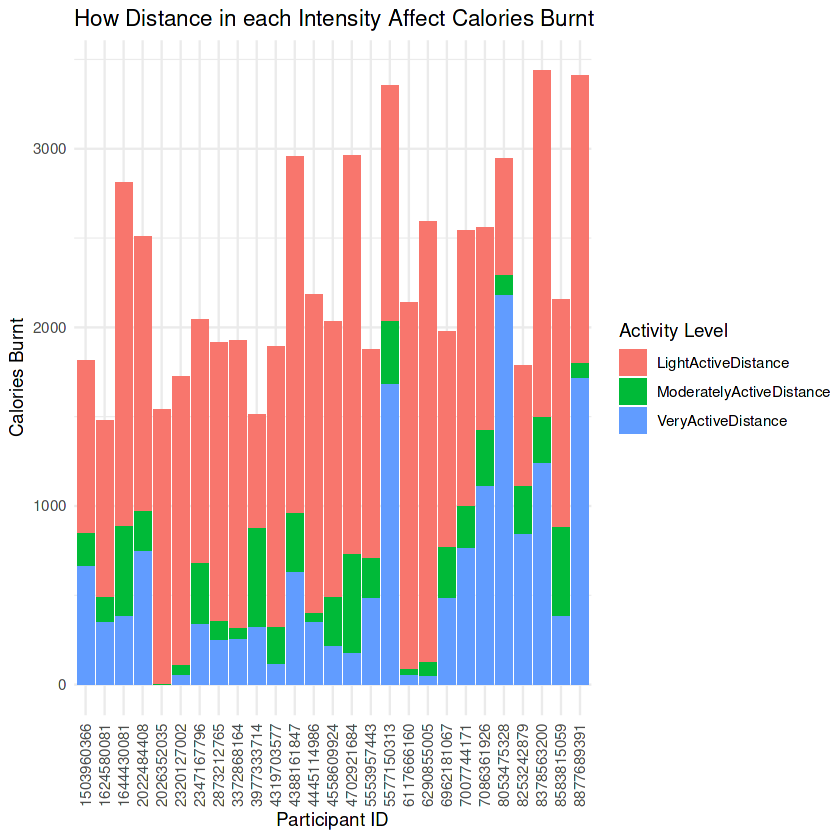

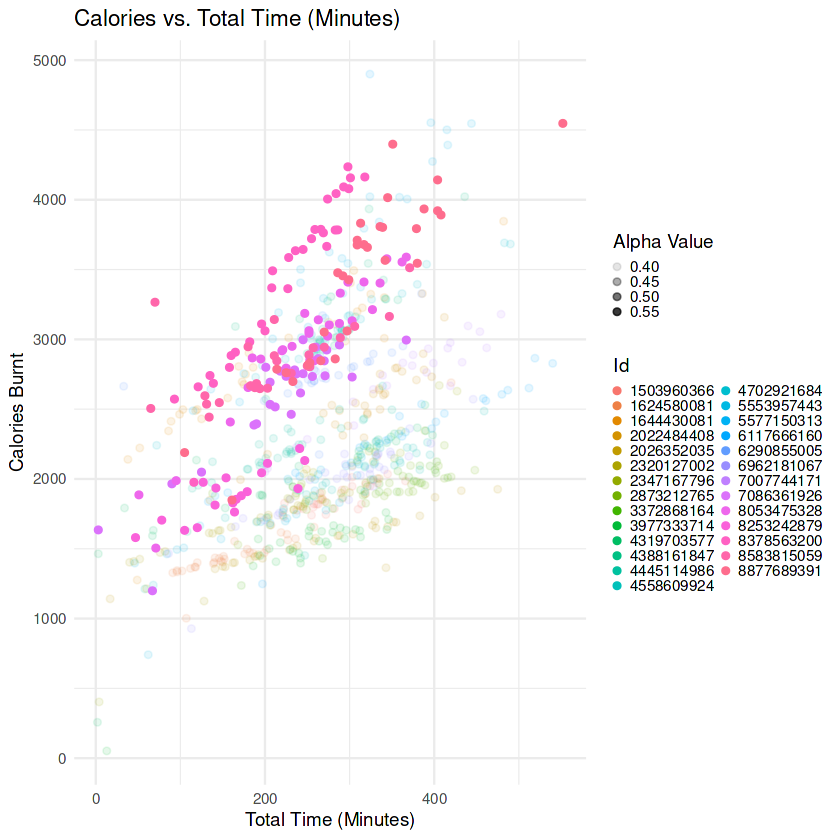

`geom_smooth()` using formula = 'y ~ x'


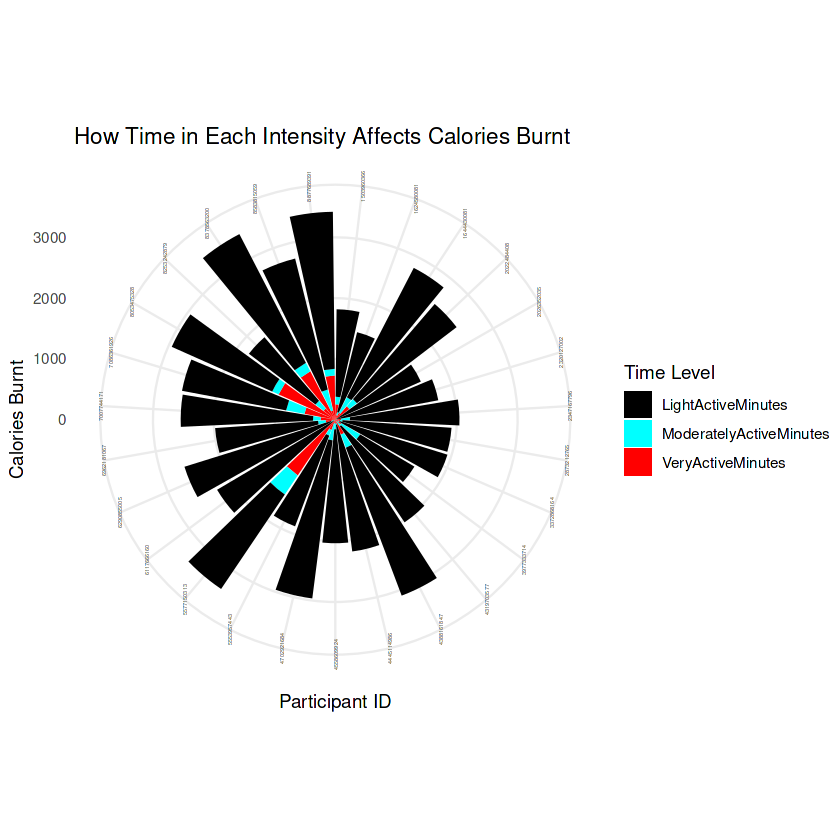

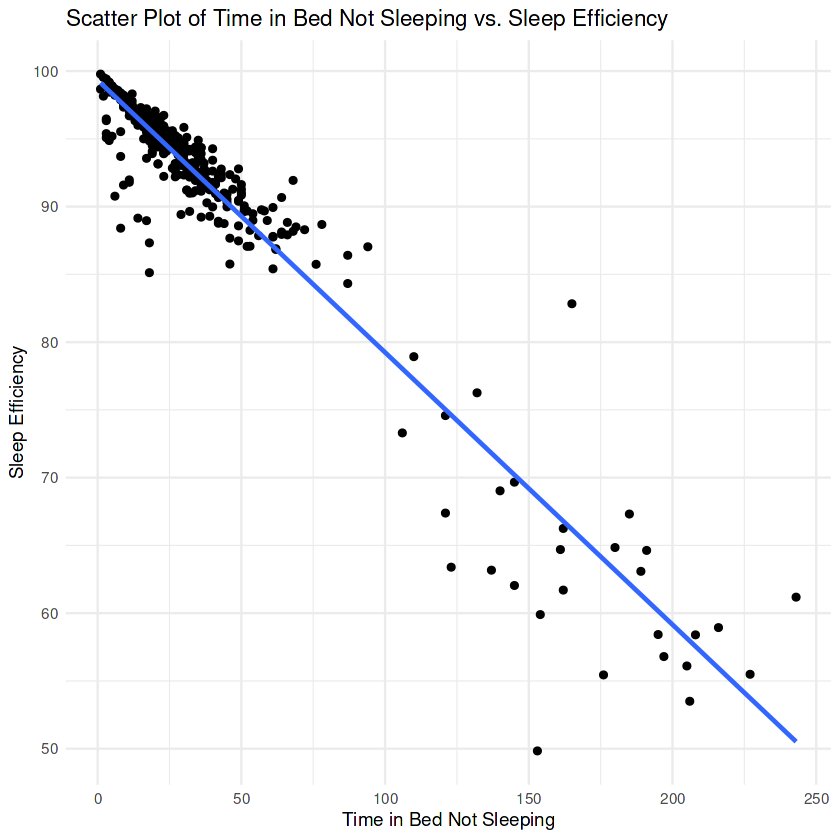

Warning message:
“Removed 30 rows containing non-finite values (`stat_boxplot()`).”


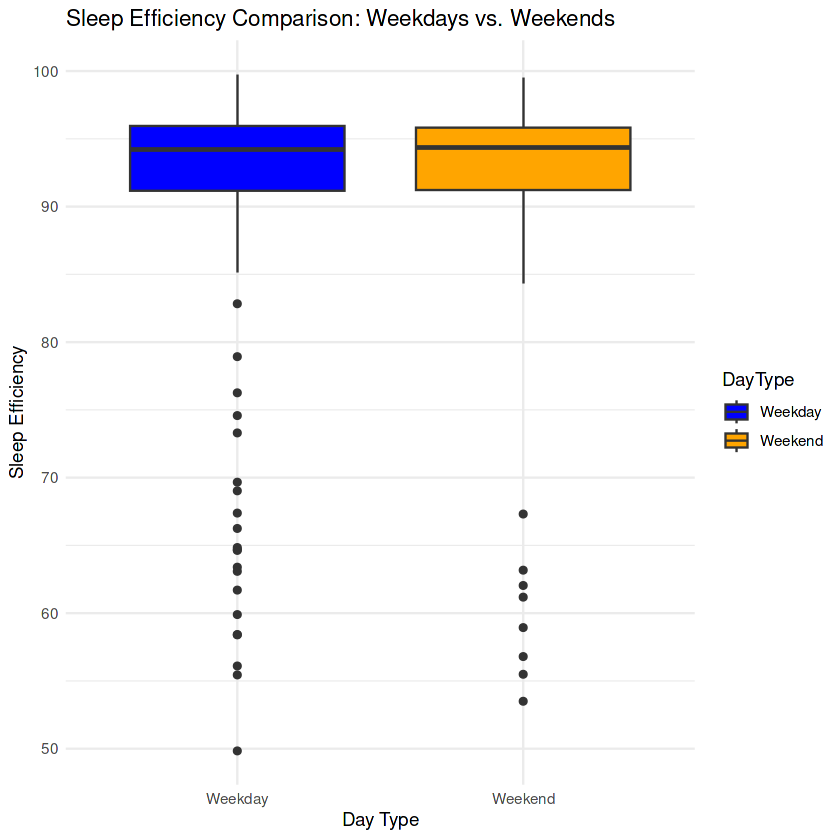

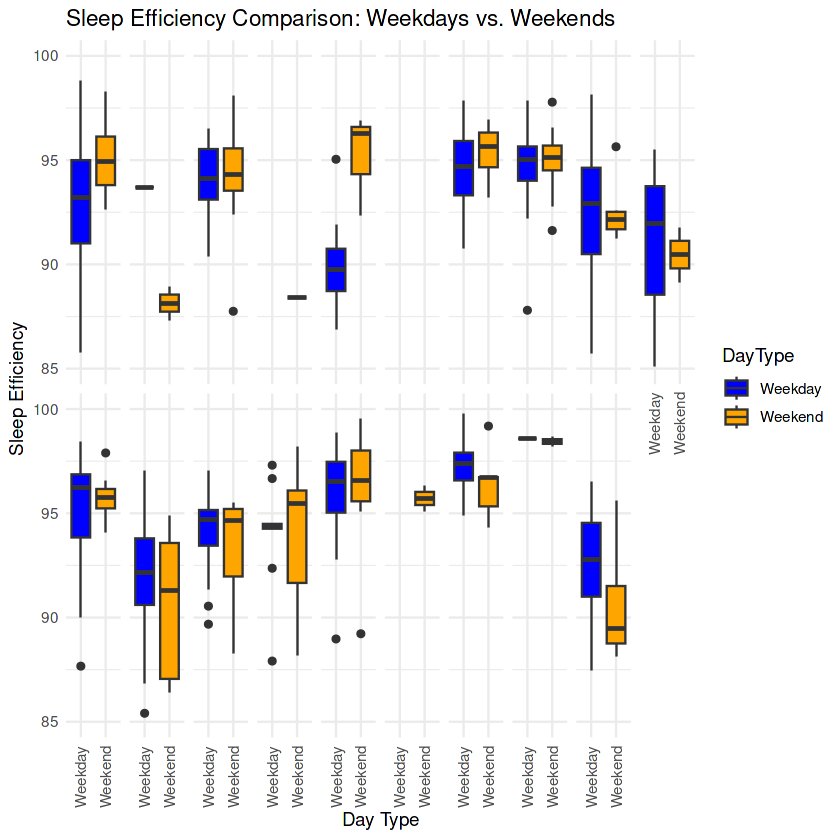

In [4]:
# We will make a new data frame containing the average distances/times/activities/calories for each ID (user). We will only investigate the activitylog data frame for now and try to draw information from it. VAD = Very active distance (How much distance is spent being very active). VAM = very active minutes (how much time is spent being very active) etc.

mean_activity_data = factivitylog %>% group_by(Id) %>% summarise(mean_steps = mean(TotalSteps), mean_dist = mean(TotalDistance), mean_VAD = mean(VeryActiveDistance), mean_MAD = mean(ModeratelyActiveDistance), mean_LAD = mean(LightActiveDistance), mean_VAM = mean(VeryActiveMinutes), mean_MAM = mean(FairlyActiveMinutes),mean_LAM = mean(LightlyActiveMinutes),mean_time = mean(Total_Time),mean_cal = mean(Calories))

#Relationship Between Total distance and Calories Burnt
first_5_ids <- tail(unique(factivitylog$Id), 6)

factivitylog$Alpha <- ifelse(factivitylog$Id %in% first_5_ids, 0.6, 0.4)

ggplot(subset(factivitylog, TotalDistance != 0), aes(TotalDistance, Calories, color = Id, alpha = Alpha)) + geom_point() +
  labs(x = "Total Distance", y = "Calories Burnt", title = "Calories vs. Total Distance",
       alpha = "Alpha Value") +
  theme_minimal() + theme(legend.key.size = unit(0.05, "cm"))

#The Graph above shows us that the relationship between Total distance and calories burnt for most individuals are linear. This "confirms" the assumption that a linear relationship exists between the two and is important to make a stacked bar chart. Some further assumptions will also be made. 

mean_activity_data = mean_activity_data %>% mutate(prop_VAD = (mean_VAD/mean_dist)*mean_cal, prop_MAD = (mean_MAD/mean_dist)*mean_cal, prop_LAD = (mean_LAD/mean_dist)*mean_cal)

flong_data = gather(mean_activity_data,key = "Activitylvl", value = "Values",prop_VAD,prop_MAD,prop_LAD)

ggplot(flong_data, aes(Id, Values, fill = Activitylvl)) +
  geom_bar(position = "stack", stat = "identity") +
  labs(x = "Participant ID", y = "Calories Burnt", fill = "Activity Level",
       title = "How Distance in each Intensity Affect Calories Burnt") +
  scale_fill_discrete(labels = c("LightActiveDistance", "ModeratelyActiveDistance", "VeryActiveDistance")) +
  theme_minimal() +  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) 

#Investigating how the amount of time that is spent on a particular intensity affects the calories burnt. 

last_5_ids <- head(unique(factivitylog$Id), 6)

factivitylog$Alpha <- ifelse(factivitylog$Id %in% first_5_ids, 0.6, 0.4)

#Subsetting the data such that if the total time is 0, the data point is ignored
ggplot(subset(factivitylog, Total_Time != 0), aes(Total_Time, Calories, color = Id, alpha = Alpha)) +
  geom_point() +
  labs(x = "Total Time (Minutes)", y = "Calories Burnt", title = "Calories vs. Total Time (Minutes)",
       alpha = "Alpha Value") +
  theme_minimal() +
  theme(legend.key.size = unit(0.05, "cm"))

#Stacked Bar chart to show the relationships between time spent in each intensity (very, moderate, light) and calories burnt.

mean_activity_data = mean_activity_data %>% mutate(prop_VAM = (mean_VAM/mean_time)*mean_cal, prop_MAM = (mean_MAM/mean_time)*mean_cal, prop_LAM = (mean_LAM/mean_time)*mean_cal)

flong_data = gather(mean_activity_data,key = "Timelvl", value = "ValuesTime",prop_VAM,prop_MAM,prop_LAM)

custom_colors <- c("black", "cyan", "red")

ggplot(flong_data, aes(Id, ValuesTime, fill = Timelvl)) +
  geom_bar(position = "stack", stat = "identity") +
  labs(x = "Participant ID", y = "Calories Burnt", fill = "Time Level",
       title = "How Time in Each Intensity Affects Calories Burnt") +
  scale_fill_manual(labels = c("LightActiveMinutes", "ModeratelyActiveMinutes", "VeryActiveMinutes"),
                    values = custom_colors) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, size = 3)) +
  coord_polar() 

#Sleep Log Visualization
#Time in Bed Not sleeping
fsleeplog = fsleeplog %>% mutate(TimeInBedNotSleeping = TotalTimeInBed - TotalMinutesAsleep)

#sleep efficiency (Higher is Better)
fsleeplog = fsleeplog %>% mutate(sleepEfficiency =  (TotalMinutesAsleep/TotalTimeInBed)*100)

#The longer you are awake in bed the worse sleep efficiency you have
ggplot(fsleeplog, aes(TimeInBedNotSleeping, sleepEfficiency)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE) +  # Add linear model line 
  labs(title = "Scatter Plot of Time in Bed Not Sleeping vs. Sleep Efficiency",
       x = "Time in Bed Not Sleeping", y = "Sleep Efficiency") +
  theme_minimal()

#Sleep: weekends vs weekdays (efficiency comparison)

fsleeplog <- fsleeplog %>%
  mutate(DayType = ifelse(weekdays(SleepDay) %in% c("Saturday", "Sunday"), "Weekend", "Weekday"))

ggplot(fsleeplog, aes(x = DayType, y = sleepEfficiency, fill = DayType)) +
  geom_boxplot() +
  labs(title = "Sleep Efficiency Comparison: Weekdays vs. Weekends",
       x = "Day Type", y = "Sleep Efficiency") +
  scale_fill_manual(values = c("Weekday" = "blue", "Weekend" = "orange")) +
  theme_minimal() #On average, there doesnt seem to be a difference between sleep efficiency during weekdays vs weekends. Hence the resolution needs to be changed. 

#weekday vs weekend comparison for each ID
ggplot(fsleeplog, aes(x = DayType, y = sleepEfficiency, fill = DayType)) +
  geom_boxplot() +
  labs(title = "Sleep Efficiency Comparison: Weekdays vs. Weekends",
       x = "Day Type", y = "Sleep Efficiency") +
  scale_fill_manual(values = c("Weekday" = "blue", "Weekend" = "orange")) +
  theme_minimal() +
  facet_wrap(~Id, ncol = 10) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),strip.text = element_blank()) + ylim(85, 100) #y axis adjusted to better comprehend the data

# 5. Analysis / Suggestions Made For Bella Beats Product/s
The analysis of the above visualizations demonstrates how increasing physical activity positively impacts calorie expenditure, aligning with Bella Beat's health-focused mission. The linear relationship between total distance and calories burnt shown in the "Calories vs Total Distance" scatterplot highlights the need to encourage users to engage in more physical activities. The stacked bar chart "How distance in each Intensity Affects Calories Burnt" shows the significance of promoting lighter activities in Bella Beat's offerings, such as walking or light exercise, as they resulted in the highest calorie burn. Additionally, the chart "How Time in Each Intensity Affects Calories Burnt" indicates that longer activity-durations spent doing light activities lead to higher calorie expenditure as well, emphasizing the importance of setting goals for longer periods. Overall, the findings support the idea of emphasizing lighter activities and providing tools for tracking and monitoring them to help users achieve their fitness goals and overall well-being.

The analysis also reveals interesting patterns in participants' sleep habits. The negative correlation between time in bed not sleeping and sleep efficiency underscores the importance of promoting better sleep practices and habits among users. Bella Beat can address this by offering personalized sleep tracking and analysis through its app and Leaf (Wellness Tracker). Providing users with actionable insights to improve their sleep quality will contribute to better overall well-being. Furthermore, the observation of differences in sleep patterns between weekdays and weekends for participants presents an opportunity for Bella Beat to offer targeted sleep improvement features that cater to individual sleep needs, depending on the day of the week. By developing tailored sleep improvement strategies based on individual variations in sleep efficiency, Bella Beat can enhance its product offerings and provide a more personalized experience to users.

To capitalize on these insights, Bella Beat can enhance its Bella Beat app and Leaf (Wellness Tracker) to offer personalized activity tracking, goal-setting features, and sleep analysis. Moreover, integrating sleep tracking and efficiency monitoring will provide users with a comprehensive view of their health, aligning with Bella Beat's health-focused approach. Incorporating actions, such as "Light Activity Challenges" and "Guided Light Workouts," Bella Beat can actively motivate users to embrace more light activities, leading to improved health outcomes and customer engagement. Moreover, implementing "In-App Rewards" and "Activity Progress Tracker" will incentivize users to maintain consistent activity levels, contributing to long-term user retention. By focusing on personalized sleep analysis and recommendations through the "Smart Coach" feature, Bella Beat can help users develop healthier sleep patterns and enhance their overall well-being. 

By embracing these comprehensive insights and implementing the suggested actions, Bella Beat can solidify its position as a leader in health-focused smart devices for women. Through a user-centric approach, Bella Beat can continuously enhance its product offerings, drive customer satisfaction, and achieve sustainable growth in the competitive market of health-focused products.